In [1]:
import pandas as pd
import time
import geopandas
from glob import glob
from shapely.ops import cascaded_union
import pickle
import matplotlib.pyplot as plt

In [2]:
bids = pd.read_csv("data/all_bids.csv")[["round", "bidder", "tier", "latency", "census_id"]]
bids["state"] = bids["census_id"]//10000000000
bids_unfiltered = bids
bids = bids.drop_duplicates(subset=["bidder", "census_id"])
bids

,round,bidder,tier,latency,census_id,state
0,1,Rainbow Communications LLC,Gigabit,Low,200050816001,20
1,1,Rainbow Communications LLC,Gigabit,Low,200050816002,20
2,1,Rainbow Communications LLC,Gigabit,Low,200050816003,20
3,1,Rainbow Communications LLC,Gigabit,Low,200050816005,20
4,1,Rainbow Communications LLC,Gigabit,Low,200050817002,20
...,...,...,...,...,...,...
4038929,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159503002,27
4038930,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159504001,27
4039029,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,270753701003,27
4039401,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,550539604003,55


In [3]:
name_map = {
    "CCO Holdings, LLC":"Charter Communications Inc",
    "Windstream Services LLC, Debtor-In-Possession":"Windstream Holdings, Inc.",
    "Connect Everyone LLC":"Starry, Inc.",
    "Frontier Communications Corporation, DIP":"Frontier Communications Corporation",
    "California Internet, L.P. dba GeoLinks":"GeoLinks",
    "Etheric Communications LLC":"Etheric Networks, Inc.",
    "Consolidated  Communications, Inc.":"Consolidated Communications, Inc.",
    "Frontier Communications Northwest, LLC":"Ziply Fiber",
    "Citynet West Virginia, LLC":"Citynet, LLC", 
    "Computer 5, Inc. d/b/a LocalTel Communications": "LocalTel Communications",
    "Armstrong Telephone Company - Northern Division": "Armstrong Holdings, Inc.",
    "Commnet Wireless, LLC": "ATN International, Inc.",
    "Mediacom Communications Corporation": "Mediacom Communications Corp.",
    "Continental Divide Electric Cooperative": "Continental Divide Electric Cooperative, Inc.",
    "South Arkansas Telephone Company": "South Arkansas Telephone Co.",
    "Digital Connections Inc. dba PRODIGI": "Digital Connections, Inc.",
    "Shenandoah Cable Television, LLC": "Shenandoah Telecommunications Company",
    "Direct Communications Rockland, Inc": "Direct Communications Rockland, Inc.",
    "Pine Belt Communications, Inc.":"Pine Belt Communications Co. Inc.",
    "Savage Communications":"Savage Communications Inc.",
    "Hamilton County Telephone Co-op":"Hamilton County Telephone Co-Op",
    "Hotwire Communications, Ltd":"Hotwire Communications Ltd.",
    "Altice USA, Inc.":"Altice",
    "TruVista Communications, Inc.":"TruVista Communications of Georgia, LLC",
    "Hawaii Dialogix Telecom LLC":"Hawaii Dialogix Telecom LLC",
    "Safelink Internet LLC":"Safelink Internet",
    "American Heartland":"Farmers Telephone Company",
    "Cellular Services LLC.":"Cellular Services LLC",
    "Scott County Telephone Cooperative, Inc.":"Scott County",
    "Micrologic Inc.":"Micrologic, Inc.",
    "Pioneer Wireless, Inc":"Pioneer Wireless, Inc.",
    "St. John Telco":"St. John Telephone, Inc.",
    "One Ring Networks, Inc":"One Ring Networks, Inc.",
    "Emery Telephone dba Emery Telcom":"Emery Telcom",
    "XIT Telecommunication & Technology":"XIT Rural Telephone Cooperative, Inc.",
    "Somerset Telephone Co., Inc.":"SOMERSET TELEPHONE COMPANY",
    "Siuslaw Broadband, LLC dba Hyak Technologies":"Siuslaw Broadband, LLC",
    "Minnesota Connections c/o Consolidated Tel Company":"Consolidated Telephone Company",
    "DoCoMo Pacific, Inc.":"Docomo Pacific",
    "Roseau Electric Cooperative, Inc.":"Roseau Electric Cooperative",
    "Custer Telephone Cooperative, Inc.":"Custer Telephone Cooperative Inc.",
    "Lakeland Communications Group, LLC":"Lakeland Communications, Inc.",
    "LigTel Communications, Inc.":"Ligtel Communications",
    "Hamilton Long Distance Company":"Hamilton.net, Inc.",
    "Allen's T.V. Cable Service, Inc.":"Allen's TV Cable Service, Inc.",
    "W. T. Services, Inc.":"W.T. Services, Inc.",
    "Heart of the Catskills Comm. Inc., dba MTC Cable":"MTC Cable",
    "Citizens Vermont Acquisition Corporation":"Citizens Telephone Company",
    "Nova Cablevision, Inc":"Nova Cablevision, Inc.",
    "yondoo Broadband LLC":"yondoo Broadband, LLC",
    "Baraga Telephone Company":"Baraga Telephone Company Inc.",
    "Miles Communications LLC":"Miles Communications, Inc.",
    "PVT NetWorks, Inc.":"Penasco Valley Telephone Cooperative, Inc.",
    "Yucca Telecommunications Systems, Inc.":"Yucca Telecom",
    "H&B Communication's, Inc.":"H&B Enterprises Inc.",
    "MARQUETTE-ADAMS TELEPHONE COOPERATIVE, INC.":"Marquette-Adams Telephone Cooperative, Inc.",
    "Pinpoint Bidding Coalition":"Pinpoint Holdings, Inc.",
    "Computer Techniques, Inc. dba CTI Fiber":"CTI Fiber",
    "Barry Technology Services, LLC":"Barry Technology Services",
    "Bloosurf, LLC":"Bloosurf",
    "St Paul Cooperative Telephone Association":"St Paul Coop Telephone Assoc",
    "Farmers Mutual Cooperative Telephone Company":"FARMERS MUTUAL TELEPHONE COMPANY",
    "NTS Communications, LLC":"NTS, Inc.",
    "Unified Communications Inc.":"Unified Communications, Inc.",
    "Peoples Communication, LLC.":"Peoples Communication, Inc.",
    "Wood County Telephone Company d/b/a Solarus":"Solarus",
    "Comcell Inc.":"Comcell, Inc.",
    "Taylor Telephone Coop., Inc. dba Taylor Telecom":"Taylor Telephone Cooperative, Inc.",
    "Plateau Telecommunications, Incorporated":"Plateau",
    "AMA Communications, LLC":"AMA Communicaitons, L.L.C.",
    "AirCell, Inc.":"AirCell",
    "Bays-ET Highspeed LLC":"Bays-ET Highspeed Internet LLC",
    "Big Bend Telecom LTD":"Big Bend Telephone Company, Inc.",
    "Blue Ridge Cable Technologies, Inc.":"Blue Ridge Cable Technologies, Inc.",
    "Cass Cable TV, Inc.":"Cass Cable TV, Inc.",
    "City of Wilson GreenLight":"City of Wilson",
    "Climax Telephone Company dba CTS Telecom, Inc.":"Climax Telephone Company",
    "Cumberland Telephone Company, Inc":"CUMBERLAND TELEPHONE COMPANY",
    "Cumby Telephone Coooertive, Inc.":"Cumby Telephone Coop., Inc.",
    "Data Stream Mobile Technoligies Inc.":"Data Stream",
    "Get Wireless Inc":"Getwireless.net",
    "Hartington Telecommunications Co., Inc,":"Hartington Telecommunications Co., Inc.",
    "Hilliary Communications Consortium":"Hilliary Communications, LLC",
    "Hillsboro Telephone Company,  Inc.":"Hillsboro Telephone Company",
    "Home Telephone ILEC, LLC":"Home Telephone ILEC, LLC d/b/a Home Telecom",
    "Hood Canal Telephone Co., Inc":"Hood Canal Communications",
    "Kingdom Telecommunications, Inc.":"Kingdom Telecommunications Inc",
    "Lincolnville Communications":"Lincolnville Telephone Company",
    "Local Internet Service Company, Inc.":"Local Internet Service Company",
    "Martell Enterprise  Inc.":"Martell Enterprises, Inc.",
    "Massena Telephone Company, Inc.":"Massena Telephone Company",
    "Moundridge Telephone Company":"Moundridge Telephone Co.",
    "MyServer.org, Inc dba San Diego Broadband":"San Diego Broadband",
    "Newbreak Management, LLC":"Newbreak Communications",
    "NexGenAccess Incorporated":"NexGenAccess",
    "Northwoods Communication Technologies, LLC":"Northwoodsconnect",
    "One Point Technologies Inc":"One Point Technologies Inc.",
    "Panhandle Telecommunication Systems, Inc.":"Panhandle Telephone Cooperative, Inc.",
    "Pathwayz Communications Inc":"Pathwayz Communications, Inc.",
    "RONAN TELEPHONE COMPANY":"Ronan Telephone Co",
    "Rainbow Communications LLC":"Rainbow Telecommunications Association, Inc.",
    "SOUTHWEST ARKANSAS TELEPHONE COOPERATIVE, INC.":"Southwest Arkansas Telephone Cooperative, Inc.",
    "South Central Wireless, Inc.":"South Central Wireless Inc.",
    "Southern Montana Telephone Company (SMTC)":"Southern Montana Telephone Company",
    "Steelville Telephone Exchange Inc.":"Steelville Telephone Exchange Inc",
    "Tekstar Communications, Inc. dba Arvig":"Arvig Enterprises, Inc.",
    "Upsala Cooperative Telephone Association dba Sytek":"UPSALA COOPERATIVE TELEPHONE ASSOCIATION",
    "Valley Telephone Cooperative, Inc":"Valley Telephone Cooperative, Inc.",
    "Velocity.Net Communications, Inc.":"Velocity Communications, Inc.",
    "Woodstock Telephone Co.":"Woodstock Telephone Company",
    "ZIRKEL Wireless, LLC":"Zirkel Wireless",
    "coon valley cooperative telephone association inc.":"Coon Valley Co-op Telephone Association, Inc.",
}

bids["bidder"] = bids["bidder"].map(lambda x: name_map[x] if x in name_map else x)
bids_unfiltered["bidder"] = bids_unfiltered["bidder"].map(lambda x: name_map[x] if x in name_map else x)
bids

/var/folders/18/gn_h02yd70g1wz5b9_6hcjjr0000gq/T/ipykernel_6049/2417878143.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bids["bidder"] = bids["bidder"].map(lambda x: name_map[x] if x in name_map else x)


,round,bidder,tier,latency,census_id,state
0,1,"Rainbow Telecommunications Association, Inc.",Gigabit,Low,200050816001,20
1,1,"Rainbow Telecommunications Association, Inc.",Gigabit,Low,200050816002,20
2,1,"Rainbow Telecommunications Association, Inc.",Gigabit,Low,200050816003,20
3,1,"Rainbow Telecommunications Association, Inc.",Gigabit,Low,200050816005,20
4,1,"Rainbow Telecommunications Association, Inc.",Gigabit,Low,200050817002,20
...,...,...,...,...,...,...
4038929,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159503002,27
4038930,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,271159504001,27
4039029,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,270753701003,27
4039401,13,Consortium of AEG and Heron Broadband I,Gigabit,Low,550539604003,55


In [4]:
existing = pd.read_csv("data/existing_service.csv", encoding="latin")
existing["bg"] = existing["BlockCode"]//1000
existing  = existing.loc[(existing["MaxAdDown"]>=25) & (existing["MaxAdUp"]>=3) & (existing["TechCode"]!=60)]
existing["state"] = existing["bg"]//10000000000
existing['names'] = [frozenset(x) for x in zip(existing.ProviderName, existing.HoldingCompanyName, existing.DBAName, existing.HocoFinal)]
existing

,LogRecNo,Provider_Id,FRN,ProviderName,DBAName,HoldingCompanyName,HocoNum,HocoFinal,StateAbbr,BlockCode,TechCode,Consumer,MaxAdDown,MaxAdUp,Business,bg,state,names
0,1,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501002019,70,1,40.0,10.0,1,410139501002,41,"(Webformix, Webformix Company)"
1,2,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139503002023,70,1,40.0,10.0,1,410139503002,41,"(Webformix, Webformix Company)"
2,3,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139502002027,70,1,40.0,10.0,1,410139502002,41,"(Webformix, Webformix Company)"
3,4,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139501003004,70,1,40.0,10.0,1,410139501003,41,"(Webformix, Webformix Company)"
4,5,59590,17678236,Webformix Company,Webformix,Webformix Company,290118,Webformix Company,OR,410139504001109,70,1,40.0,10.0,1,410139504001,41,"(Webformix, Webformix Company)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42151570,42151571,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003006,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., Osnet Wireless Corp., O..."
42151571,42151572,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003005,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., Osnet Wireless Corp., O..."
42151572,42151573,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003004,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., Osnet Wireless Corp., O..."
42151573,42151574,79963,21999305,OSNET Wireless Corp.,OSNET Wireless,OSNET Wireless Corp.,420091,Osnet Wireless Corp.,PR,720054006003003,70,1,30.0,10.0,1,720054006003,72,"(OSNET Wireless Corp., Osnet Wireless Corp., O..."


In [5]:
existing_bg = set(existing["bg"].tolist())
bid_bg = set(bids["census_id"].tolist())
print(len(existing_bg))
print(len(bid_bg))
print(len(existing_bg.intersection(bid_bg)))


219391
61766
61021


In [6]:
eligible = pd.read_csv("data/auction904_updated_block_cbg.csv")
eligible_bg = eligible["cbg_id"].tolist()
print(len(set(eligible_bg)))
eligible_b = eligible["block_id"].tolist()
existing_b = set(existing["BlockCode"].tolist())
print(len(existing_b))
print(len(eligible_b))
intersect = existing_b.intersection(eligible_b)
print(len(existing_b.intersection(eligible_b)))
print(list(intersect)[:5])


61766
8063170
786952
292114
[170679543005184, 170679543005185, 170679543005186, 170679543005187, 170679543005188]


In [7]:
shapefiles = glob("data/all_data/*.shp")
county_shapes = []
for file in  shapefiles:
    county_shapes.append(geopandas.read_file(file))

county_shapes = pd.concat(county_shapes)[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE", "GEOID", "geometry"]]
county_shapes["GEOID"] = pd.to_numeric(county_shapes["GEOID"])
county_shapes

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,geometry
0,05,143,010503,2,51430105032,"POLYGON ((-94.21915 36.17593, -94.21718 36.175..."
1,05,143,010504,1,51430105041,"POLYGON ((-94.33762 35.97984, -94.33724 35.980..."
2,05,143,010504,5,51430105045,"POLYGON ((-94.43864 35.95907, -94.43852 35.959..."
3,05,143,010506,1,51430105061,"POLYGON ((-94.24059 36.04502, -94.24058 36.045..."
4,05,135,470200,7,51354702007,"POLYGON ((-91.54745 36.26023, -91.54734 36.260..."
...,...,...,...,...,...,...
3921,24,003,740601,4,240037406014,"POLYGON ((-76.77774 39.11425, -76.77746 39.114..."
3922,24,510,160500,1,245101605001,"POLYGON ((-76.66090 39.30614, -76.66017 39.306..."
3923,24,510,160500,2,245101605002,"POLYGON ((-76.65502 39.29848, -76.65464 39.298..."
3924,24,510,160500,3,245101605003,"POLYGON ((-76.65941 39.29463, -76.65892 39.294..."


In [8]:
try:
    state_shapes = pickle.load(open("state_shapes.pkl", "rb" ))
except FileNotFoundError:
    state_shapes = county_shapes.groupby("STATEFP")["geometry"].apply(list).reset_index(name="geometry")
    state_shapes["geometry"] = state_shapes["geometry"].apply(cascaded_union)
    state_shapes = geopandas.GeoDataFrame(state_shapes)
    for index, row in state_shapes.iterrows():
        neighbors = state_shapes[~state_shapes.geometry.disjoint(row['geometry'])]
        state_shapes.at[index, "neighbors"] = ", ".join(neighbors.STATEFP.tolist())
    with open('state_shapes.pkl', 'wb') as f:
        pickle.dump(state_shapes, f)

In [9]:
try:
    processed_bid_dict = pickle.load(open("neighbors.pkl", "rb" ))
except FileNotFoundError:
    with open("neighbors.log", "w") as log:
        pass

    total_time = 0
    processed_bid_dict = {}
    for state_code in state_shapes["STATEFP"].tolist():
        print(state_code)
        start = time.time()
        state_bids = bids.loc[bids["state"]==int(state_code)]
        state_bids = state_bids.groupby("census_id")["bidder"].apply(set).reset_index(name="bidder")
        state_bids = state_bids.merge(county_shapes, left_on="census_id", right_on="GEOID")

        neighbors = state_shapes.loc[state_shapes["STATEFP"] == state_code]["neighbors"].item().split(", ")
        neighbors = [int(n) for n in neighbors]
        state_existing = existing.loc[existing["state"].isin(neighbors)]
        state_existing = state_existing.groupby("bg")["names"].apply(set).reset_index(name="names")
        state_existing = state_existing.merge(county_shapes, left_on="bg", right_on="GEOID")
        state_existing = geopandas.GeoDataFrame(state_existing)

        for index, row in state_bids.iterrows():
            neighbors = state_existing[~state_existing.geometry.disjoint(row['geometry'])]
            ids = neighbors.GEOID.tolist()
            list_set_set_names = neighbors.names.tolist()
            bidders = row.bidder
            out = {}
            for idx, set_set_names in zip(ids, list_set_set_names):
                for name_possibilities in set_set_names:
                    for bidder in bidders:
                        if bidder in name_possibilities:
                            running = out.get(bidder, [])
                            running.append(idx)
                            out[bidder] = running
            state_bids.at[index, "neighbors"] = [out]
        state_time = time.time()-start
        with open("neighbors.log", "a") as log:
            log.write(f"{state_code} {state_time}\n")
        total_time += state_time
        processed_bid_dict[state_code] = state_bids
        print(state_time)

    with open("neighbors.log", "a") as log:
        log.write(f"final time {total_time}")

    with open('neighbors.pkl', 'wb') as f:
        pickle.dump(processed_bid_dict, f)

In [10]:
all_neighbors = {}
all_bidders = {}
for state, table in processed_bid_dict.items():
    neighbors = {}
    bidders = {}
    for index, row in table.iterrows():
        for k, v in row.neighbors[0].items():
            running = neighbors.get(k, [])
            running += v
            neighbors[k] = running

            running = bidders.get(k, [])
            running.append(row.GEOID)
            bidders[k] = running
    print(state)
    for k, v in bidders.items():
        print(k, len(v))
    for k, v in neighbors.items():
        print(k, len(v))
    all_neighbors[state] = neighbors
    all_bidders[state] = bidders

01
Windstream Holdings, Inc. 112
CenturyLink, Inc. 212
Charter Communications Inc 347
Point Broadband Fiber Holding, LLC 17
Pine Belt Communications Co. Inc. 17
Mediacom Communications Corp. 56
Consolidated Communications, Inc. 2
Windstream Holdings, Inc. 375
CenturyLink, Inc. 1099
Charter Communications Inc 1774
Point Broadband Fiber Holding, LLC 55
Pine Belt Communications Co. Inc. 42
Mediacom Communications Corp. 300
Consolidated Communications, Inc. 18
02
04
Ponderosa Communications, Inc. 2
Valley Telephone Cooperative, Inc. 6
CenturyLink, Inc. 117
Altice 5
Cox Communications, Inc. 22
GeoLinks 26
One Ring Networks, Inc. 19
Ponderosa Communications, Inc. 7
Valley Telephone Cooperative, Inc. 17
CenturyLink, Inc. 737
Altice 22
Cox Communications, Inc. 179
GeoLinks 27
One Ring Networks, Inc. 28
05
CenturyLink, Inc. 198
Windstream Holdings, Inc. 367
Altice 34
Cox Communications, Inc. 21
South Arkansas Telephone Co. 29
Verizon Communications Inc. 2
Southwest Arkansas Telephone Cooperativ

22
Charter Communications Inc 94
CenturyLink, Inc. 108
Altice 62
Cox Communications, Inc. 114
Newbreak Communications 3
Allen's TV Cable Service, Inc. 17
Charter Communications Inc 484
CenturyLink, Inc. 476
Altice 303
Cox Communications, Inc. 997
Newbreak Communications 8
Allen's TV Cable Service, Inc. 85
23
Redzone Wireless, LLC 184
Consolidated Communications, Inc. 130
Pioneer Wireless, Inc. 22
Lincolnville Telephone Company 1
Redzone Wireless, LLC 621
Consolidated Communications, Inc. 903
Pioneer Wireless, Inc. 79
Lincolnville Telephone Company 4
24
One Ring Networks, Inc. 5
Bloosurf 139
Quantum Telecommunications, Inc. 6
Armstrong Holdings, Inc. 2
QCOL, Inc. 4
Declaration Networks Group, Inc 9
Shenandoah Telecommunications Company 6
ThinkBig Networks, LLC 24
Talkie Communications, Inc. 13
Atlantic Broadband Finance, LLC 9
Easton Utilities Commission 14
Mediacom Communications Corp. 17
One Ring Networks, Inc. 7
Bloosurf 733
Quantum Telecommunications, Inc. 11
Armstrong Holdings, Inc

39
Frontier Communications Corporation 335
Charter Communications Inc 791
Windstream Holdings, Inc. 296
CenturyLink, Inc. 147
Benton Ridge Telephone Company 63
Cincinnati Bell Inc. 13
NexGenAccess 62
Cox Communications, Inc. 1
Wabash Communications, Inc. 27
Altice 7
Rowe Wireless Networks LLC 34
Armstrong Holdings, Inc. 37
Sycamore Telephone Company 4
Frontier Communications Corporation 1804
Charter Communications Inc 5243
Windstream Holdings, Inc. 1247
CenturyLink, Inc. 769
Benton Ridge Telephone Company 231
Cincinnati Bell Inc. 113
NexGenAccess 207
Cox Communications, Inc. 4
Wabash Communications, Inc. 89
Altice 42
Rowe Wireless Networks LLC 124
Armstrong Holdings, Inc. 200
Sycamore Telephone Company 28
40
Cox Communications, Inc. 74
Windstream Holdings, Inc. 347
AMG Technology Investment Group LLC 70
Skybeam, LLC 168
Resound Networks, LLC 4
Altice 73
Hilliary Communications, LLC 44
Santa Rosa Telephone Cooperative, Inc. 9
CenturyLink, Inc. 3
KanOkla Telephone Association 7
Terral Te

<AxesSubplot:>

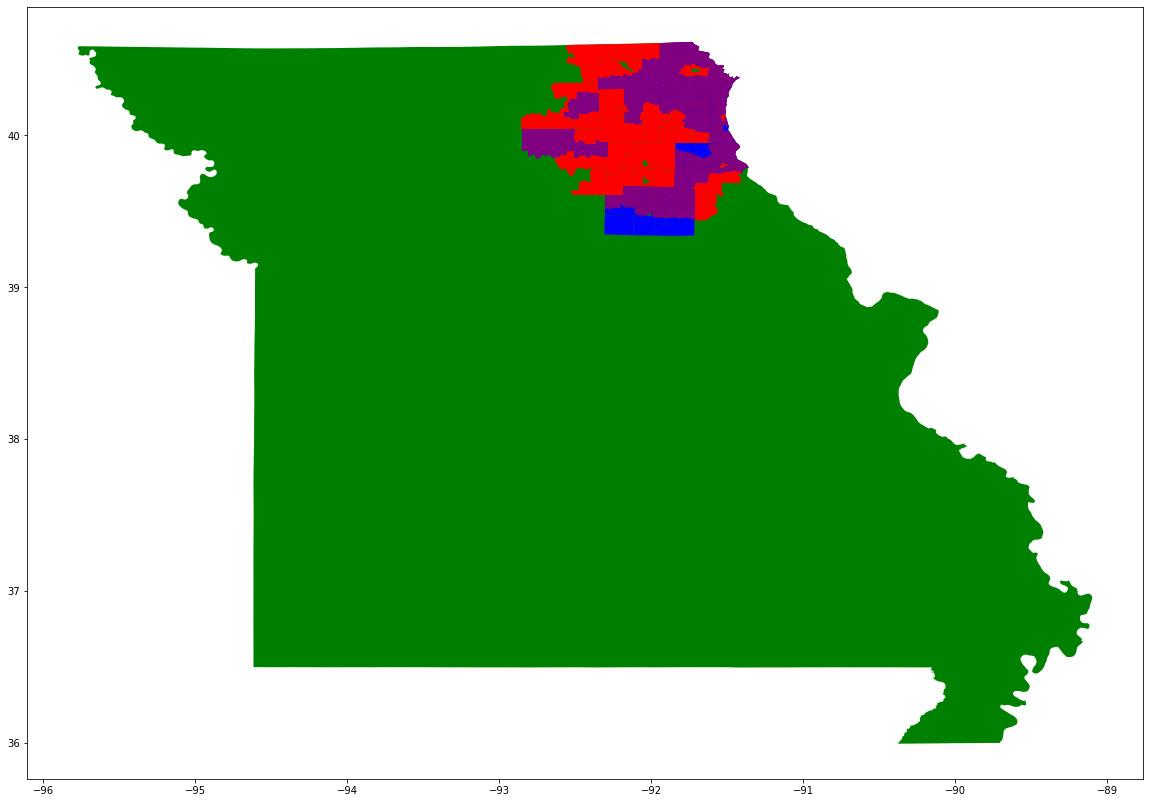

In [11]:
state = "29"
selected_bidder = "Mark Twain Communications Company"
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP"] == state].geometry.item()] 

n = set(all_neighbors[state][selected_bidder])
b = set(all_bidders[state][selected_bidder])
combined = n.intersection(b)

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(n)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(b)].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(combined)].geometry
df3["color"] = "purple"

df = pd.concat([df, df1, df2, df3])

df.plot(color=df['color'], figsize=(20, 15))


<AxesSubplot:>

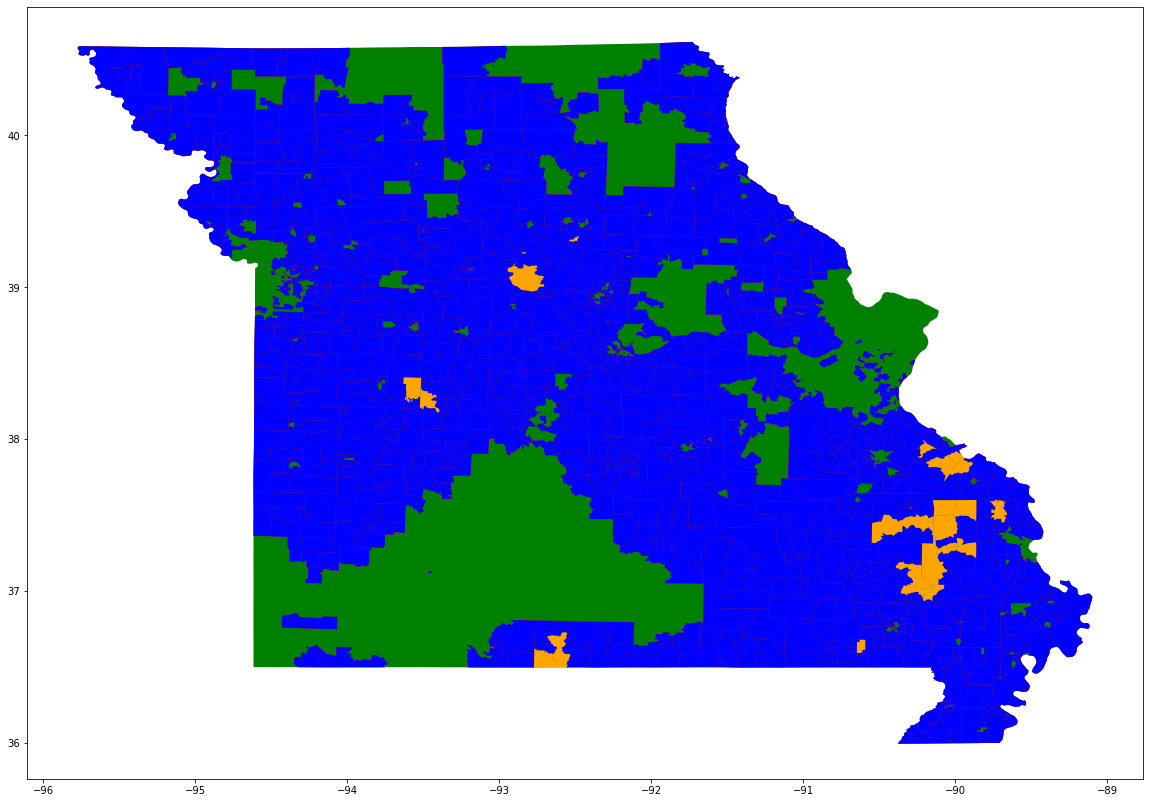

In [12]:
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df5 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

df.loc[0] = ['green', state_shapes.loc[state_shapes["STATEFP"] == state].geometry.item()] 

bid = set(processed_bid_dict[state].GEOID)
elig = set(eligible.loc[eligible.state_abbreviation=="MO"].cbg_id)
exis = set(existing.loc[existing.state==int(state)].bg).intersection(elig)
fresh = elig - exis

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(exis)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(exis.intersection(bid))].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(fresh)].geometry
df3["color"] = "purple"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(fresh.intersection(bid))].geometry
df3["color"] = "orange"

df = pd.concat([df, df1, df2, df3, df4, df5])

df.plot(color=df['color'], figsize=(20, 15))


<AxesSubplot:>

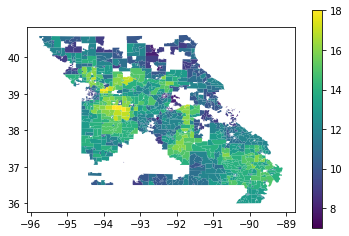

In [13]:
processed_bid_dict[state]["num_bidders"] = processed_bid_dict[state].bidder.apply(len)
fig, ax = plt.subplots(1, 1)
geopandas.GeoDataFrame(processed_bid_dict[state]).plot(column="num_bidders", ax=ax, legend=True, figsize=(20,15)) 

<AxesSubplot:>

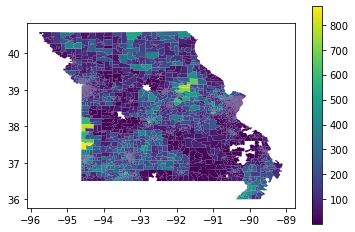

In [14]:
df = existing.loc[existing["state"]==int(state)].groupby("bg")["names"].apply(len).reset_index(name="num_existing")
df = df.merge(county_shapes, left_on="bg", right_on="GEOID")
fig, ax = plt.subplots(1, 1)
geopandas.GeoDataFrame(df).plot(column= "num_existing",ax=ax, legend=True, figsize=(20,15)) 

In [15]:
bids_unfiltered["combined_pk"] = bids_unfiltered["bidder"] + bids_unfiltered["census_id"].astype(str)
final_rounds = bids_unfiltered.groupby("combined_pk").agg({'round': 'max','bidder':'first','census_id':'first'})
winners = pd.read_csv("data/all_assigned_census_blocks.csv")[["bidder","block_id","state","census_id"]]
winners = winners.groupby(['bidder','census_id'], as_index=False).agg({"block_id":list, "state":"first"})
winners["bidder"] = winners["bidder"].map(lambda x: name_map[x] if x in name_map else x)
winners

,bidder,census_id,block_id,state
0,4-Corners Consortium,350319437004,"[350319437004005, 350319437004010, 35031943700...",NM
1,4-Corners Consortium,350319438004,"[350319438004000, 350319438004003, 35031943800...",NM
2,AB Indiana LLC,120210112021,"[120210112021071, 120210112021072, 12021011202...",FL
3,ACT,281159504002,"[281159504002011, 281159504002012, 28115950400...",MS
4,ACT,281159505001,"[281159505001024, 281159505001026, 28115950500...",MS
...,...,...,...,...
57167,Yucca Telecom,350410003002,"[350410003002004, 350410003002063]",NM
57168,Yucca Telecom,350410003003,[350410003003024],NM
57169,"Zito West Holding, LLC",420879605002,"[420879605002001, 420879605002004, 42087960500...",PA
57170,"yondoo Broadband, LLC",291138101002,"[291138101002030, 291138101002058, 29113810100...",MO


In [16]:
def explode_processed_bids(processed_bid_dict):
    list_of_rows = []
    for k, v in processed_bid_dict.items():
        for idx, row in v.iterrows():
            for bidder, neighboring_bg in row.neighbors[0].items():
                list_of_rows.append([bidder, row.bidder, row.GEOID, row.geometry, [neighboring_bg]])
    return geopandas.GeoDataFrame(list_of_rows, columns=["bidder", "competitors", "GEOID", "geometry", "neighbors"])
exploded_df = explode_processed_bids(processed_bid_dict)

In [17]:
exploded_df = exploded_df.merge(final_rounds, left_on=["GEOID", "bidder"], right_on=["census_id", "bidder"])
exploded_df_winner = exploded_df.merge(winners, on=["census_id", "bidder"])
final_rounds_winner = final_rounds.merge(winners, on=["census_id", "bidder"])
exploded_df_winner

,bidder,competitors,GEOID,geometry,neighbors,round,census_id,block_id,state
0,"CenturyLink, Inc.","{CenturyLink, Inc., Verizon Communications Inc...",10059503001,"POLYGON ((-85.58226 31.75380, -85.58225 31.753...","[[10059503001, 10059503002, 10059504001, 10059...",13,10059503001,"[10059503001000, 10059503001002, 1005950300100...",AL
1,"CenturyLink, Inc.","{CenturyLink, Inc., Viasat, Inc., Wisper-CABO ...",10059503002,"POLYGON ((-85.70896 31.71170, -85.70831 31.712...","[[10059503001, 10059503002, 10059504002, 10059...",13,10059503002,"[10059503002000, 10059503002001, 1005950300200...",AL
2,"CenturyLink, Inc.","{CenturyLink, Inc., Verizon Communications Inc...",10059504001,"POLYGON ((-85.58716 31.72665, -85.58665 31.726...","[[10059503001, 10059504001, 10059504002, 10450...",13,10059504001,"[10059504001000, 10059504001001, 1005950400100...",AL
3,"Windstream Holdings, Inc.","{Viasat, Inc., Wisper-CABO 904 Consortium, Spa...",10059505001,"POLYGON ((-85.27601 31.70443, -85.27583 31.704...","[[130619603001, 132399603002]]",13,10059505001,"[10059505001020, 10059505001077, 1005950500107...",AL
4,Charter Communications Inc,"{Viasat, Inc., Wisper-CABO 904 Consortium, RDO...",10070100011,"POLYGON ((-87.31218 33.08729, -87.31211 33.088...","[[11250107021, 11250107022, 11250107031]]",16,10070100011,"[10070100011000, 10070100011005, 1007010001100...",AL
...,...,...,...,...,...,...,...,...,...
11716,"Visionary Communications, Inc.","{Visionary Communications, Inc., Viasat, Inc.,...",560330006002,"POLYGON ((-107.30168 44.91839, -107.30160 44.9...","[[300039404001, 300039407001, 560330004001, 56...",17,560330006002,"[560330006002133, 560330006002134, 56033000600...",WY
11717,"Visionary Communications, Inc.","{Visionary Communications, Inc., Viasat, Inc.,...",560330006003,"POLYGON ((-107.14372 44.76929, -107.14359 44.7...","[[560330001004, 560330002003, 560330003003, 56...",17,560330006003,"[560330006003009, 560330006003028, 56033000600...",WY
11718,"Visionary Communications, Inc.","{Visionary Communications, Inc., CenturyLink, ...",560350001021,"POLYGON ((-109.89360 42.86531, -109.89351 42.8...","[[560130003002, 560139401001, 560350001011, 56...",14,560350001021,"[560350001021000, 560350001021004, 56035000102...",WY
11719,"CenturyLink, Inc.","{Visionary Communications, Inc., CenturyLink, ...",560350001022,"POLYGON ((-110.53416 43.28313, -110.53392 43.2...","[[560350001011, 560350001021, 560350001022, 56...",12,560350001022,"[560350001022009, 560350001022028, 56035000102...",WY


In [18]:
all_bids_by_bidder = final_rounds.groupby("bidder")["census_id"].apply(set).reset_index(name="all_bids")
all_bids_by_bidder = {k:v for k, v in zip(all_bids_by_bidder.bidder, all_bids_by_bidder.all_bids)}

all_neighbored_bids_by_bidder = exploded_df.groupby("bidder")["GEOID"].apply(set).reset_index(name="all_bids")
all_neighbored_bids_by_bidder = {k:v for k, v in zip(all_neighbored_bids_by_bidder.bidder, all_neighbored_bids_by_bidder.all_bids)}

all_neighbors_by_bidder = exploded_df.groupby("bidder")["neighbors"].apply(lambda x: set([z for y in x for z in y[0]])).reset_index(name="all_bids")
all_neighbors_by_bidder = {k:v for k, v in zip(all_neighbors_by_bidder.bidder, all_neighbors_by_bidder.all_bids)}

average_round_by_bidder = final_rounds.groupby("bidder")["round"].mean().reset_index(name="average_final_round")
average_round_by_bidder = {k:v for k, v in zip(average_round_by_bidder.bidder, average_round_by_bidder.average_final_round)}


all_bids_by_bidder_winner = final_rounds_winner.groupby("bidder")["census_id"].apply(set).reset_index(name="all_bids")
all_bids_by_bidder_winner = {k:v for k, v in zip(all_bids_by_bidder_winner.bidder, all_bids_by_bidder_winner.all_bids)}

all_neighbored_bids_by_bidder_winner = exploded_df_winner.groupby("bidder")["GEOID"].apply(set).reset_index(name="all_bids")
all_neighbored_bids_by_bidder_winner = {k:v for k, v in zip(all_neighbored_bids_by_bidder_winner.bidder, all_neighbored_bids_by_bidder_winner.all_bids)}

all_neighbors_by_bidder_winner = exploded_df_winner.groupby("bidder")["neighbors"].apply(lambda x: set([z for y in x for z in y[0]])).reset_index(name="all_bids")
all_neighbors_by_bidder_winner = {k:v for k, v in zip(all_neighbors_by_bidder_winner.bidder, all_neighbors_by_bidder_winner.all_bids)}

average_round_by_bidder_winner = final_rounds_winner.groupby("bidder")["round"].mean().reset_index(name="average_final_round")
average_round_by_bidder_winner = {k:v for k, v in zip(average_round_by_bidder_winner.bidder, average_round_by_bidder_winner.average_final_round)}

won_blocks = final_rounds_winner.groupby("bidder").agg({"census_id":list, "block_id":list}).reset_index()
won_blocks = {b:{c_id:len(b_id) for c_id, b_id in zip(c_ids, b_ids)} for b, c_ids, b_ids in zip(won_blocks.bidder, won_blocks.census_id, won_blocks.block_id)}

all_bids_by_bidder

{'1stel, Inc.': {400470016011,
  400470016012,
  170910122004,
  400470016021,
  400470016022,
  401230889001,
  401230889002,
  200299774001,
  200299774002,
  470459646001,
  470459646002,
  261570003001,
  261570003002,
  261570003003,
  261570003004,
  171790205001,
  171790205002,
  484817404001,
  484817404002,
  171670012003,
  484817404004,
  484817404005,
  484817404006,
  261390205032,
  260590502001,
  260590502002,
  484910203011,
  484910203012,
  484910203013,
  484910203021,
  484759503001,
  400173007002,
  484759503002,
  261476516001,
  261476516002,
  261476516003,
  200999502001,
  200999502002,
  260873421002,
  260873421003,
  181290402001,
  181290402002,
  181290402003,
  261158306001,
  261158306002,
  261158306003,
  400836002001,
  400836002003,
  484910203101,
  401539531001,
  484910203141,
  484910203142,
  170190111001,
  170190111002,
  180350026013,
  180350026014,
  180350026015,
  170159604001,
  170159604003,
  180350026021,
  180350026023,
  4816772

In [19]:
big_table_rows = []
for bidder, all_bids in all_bids_by_bidder.items():
    average_round = average_round_by_bidder[bidder]
    neighbored_bids = all_neighbored_bids_by_bidder.get(bidder, set())
    neighbors = all_neighbors_by_bidder.get(bidder, set())
    
    wild_tract_bg = all_bids - neighbored_bids
    strict_neighbor_bg = neighbored_bids - neighbors
    existing_bg = neighbored_bids.intersection(neighbors)
    
    
    average_round_winner = average_round_by_bidder_winner.get(bidder, 0)
    all_bids_winner = all_bids_by_bidder_winner.get(bidder, set())
    neighbored_bids_winner = all_neighbored_bids_by_bidder_winner.get(bidder, set())
    neighbors_winner = all_neighbors_by_bidder_winner.get(bidder, set())
    
    wild_tract_bg_winner = all_bids_winner - neighbored_bids_winner
    strict_neighbor_bg_winner = neighbored_bids_winner - neighbors_winner
    existing_bg_winner = neighbored_bids_winner.intersection(neighbors_winner)
    
    total_blocks = wild_blocks = strict_blocks = existing_blocks = 0
    for c_id, count in won_blocks.get(bidder, dict()).items():
        if c_id in wild_tract_bg_winner:
            wild_blocks+=count
        elif c_id in strict_neighbor_bg_winner:
            strict_blocks+=count
        else:
            existing_blocks+=count
        total_blocks+=count

    big_table_rows.append([bidder, len(wild_tract_bg), len(strict_neighbor_bg),len(existing_bg), len(neighbors),
                           len(all_bids), average_round, len(wild_tract_bg_winner), len(strict_neighbor_bg_winner),
                           len(existing_bg_winner), len(neighbors_winner), len(all_bids_winner), average_round_winner,
                           wild_blocks, strict_blocks, existing_blocks, total_blocks
                          ])
big_table_rows = sorted(big_table_rows, key=lambda x:x[2]+x[3])
percent_neighbor_by_bidder = pd.DataFrame(big_table_rows, columns=["bidder", "wild tract bids", "strict neighbor bids",
                                                                   "existing bg bids", "average neighbors per bid",
                                                                   "num bids", "average final round number",
                                                                   "wild tract bids winner",
                                                                   "strict neighbor bids winner",
                                                                   "existing bg bids winner",
                                                                   "average neighbors per bid winner", "num wins",
                                                                   "average final round number winner",
                                                                   "won blocks in wild tract bg", 
                                                                   "won blocks in strict neighbor bg", 
                                                                   "won blocks in existing bg", "total blocks won" 
                                                                  ])
percent_neighbor_by_bidder.to_csv("bidder_neighbor_percentage.csv", index=False)

In [ ]:
states = ["27", "38", "46"]
selected_bidder = "Charter Communications Inc"
df = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df1 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df2 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df3 = geopandas.GeoDataFrame(columns=['color', 'geometry'])
df4 = geopandas.GeoDataFrame(columns=['color', 'geometry'])

# df["geometry"] = state_shapes.loc[state_shapes["STATEFP"].isin(states)].geometry
# df["color"] = "green"

n = set(all_neighbors_by_bidder.get(selected_bidder, []))
h = set(all_neighbored_bids_by_bidder.get(selected_bidder, []))
b = set(all_bids_by_bidder[selected_bidder])
combined = n.intersection(b)

df1["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(n)].geometry
df1["color"] = "red"

df2["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(b)].geometry
df2["color"] = "blue"

df3["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(h)].geometry
df3["color"] = "orange"

df4["geometry"] = county_shapes.loc[county_shapes.GEOID.isin(combined)].geometry
df4["color"] = "purple"

df = pd.concat([df, df1, df2, df3, df4])

df.plot(color=df['color'], figsize=(20, 15))


In [ ]:
winners.bidder.unique()